# 2019-10-02_fkd_01_keras_simple-dense-model

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import sys
import pathlib
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from pyprojroot import here

# import project specific modules
src_p = here("110_src")
sys.path.insert(0, str(src_p))
from util import load_data, plot_img, plot_facial_keypoints, train_p

## Let's look at the data

The training set consists of a lot of labels which describe a certain marker point of a face with x and y coordinates. The last column of the DataSet is called Image and consists the image data as uint8 values aligned as a string.

In [2]:
train_df = pd.read_csv(train_p)

In [3]:
labels = list(train_df.columns[:-1])
print("Labels:", ", ".join(labels))

Labels: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, nose_tip_x, nose_tip_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y


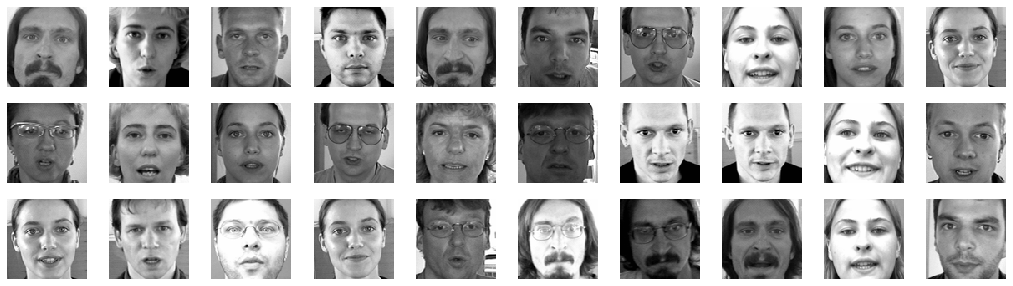

In [4]:
fig = plt.figure(figsize=(18, 5))

for i in range(30):
    ax = fig.add_subplot(3, 10, i+1)
    plot_img(train_df.iloc[i].Image)

In [66]:
def f(i):
    plot_facial_keypoints(train_df.iloc[i])
    
interact(f, i=widgets.IntSlider(10, min=0, max=train_df.shape[0]));

interactive(children=(IntSlider(value=10, description='i', max=7049), Output()), _dom_classes=('widget-interac…

## Let's begin with the tip of the nose

In [69]:
X_train, Y_train, X_test = load_data(labels=["nose_tip_x", "nose_tip_y"])

# do only use images until 2283 because the labels for later images are somehow inaccurate
X_train = X_train[:2283]
Y_train = Y_train[:2283]

# normalize input and output data for faster training
X_train = (X_train.astype(np.float32) / 255.0)
Y_train = (Y_train.astype(np.float32) / 96.0)
X_test = (X_test.astype(np.float32) / 255.0)

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [71]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.activations import tanh
from keras_tqdm import TQDMNotebookCallback

In [84]:
model = Sequential([
    Dense(1000, activation="tanh"),
    Dense(500, activation="tanh"),
    Dense(100, activation="tanh"),
    Dense(50, activation="tanh"),
    Dense(2)
])
model.compile(Adam(lr=0.00001), loss="mse")

In [85]:
history = model.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=64,
    verbose=0,
    callbacks=[TQDMNotebookCallback(metric_format="{value:.6f}")],
)

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history["loss"])

In [78]:
from sklearn.metrics import mean_squared_error

Y_train_pred = model.predict(X_train)
Y_dev_pred = model.predict(X_dev)

mse_train = mean_squared_error(Y_train, Y_train_pred)
mse_dev = mean_squared_error(Y_dev, Y_dev_pred)

print(f"MSE (training): {mse_train:.6f}")
print(f"MSE (dev): {mse_dev:.5f}")

MSE (training): 0.000554
MSE (dev): 0.00194


In [79]:
def f(i):
    y_pred = model.predict(np.array([X_dev[i]]))
    
    plt.plot(y_pred[0][0] * 96.0, y_pred[0][1] * 96.0, "or")
    plt.plot(Y_dev[i][0] * 96.0, Y_dev[i][1] * 96.0, "og")
    
    plt.imshow((X_dev[i] * 255.0).astype(np.uint8).reshape(96, 96), cmap="gray")
    
interact(f, i=widgets.IntSlider(10, min=0, max=100))

interactive(children=(IntSlider(value=10, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.f(i)>

In [13]:
results_p = here("030_results")
model.load_weights(str(results_p / "weights01_tf1.14_keras2.3.0.h5"))